In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
device

device(type='cuda')

In [80]:
manifest = pd.read_csv("./AD_Patient_Manifest.csv")
manifest

,PTID,path
0,002_S_0295,patients_csv\002_S_0295.pkl
1,002_S_0413,patients_csv\002_S_0413.pkl
2,002_S_0619,patients_csv\002_S_0619.pkl
3,002_S_0685,patients_csv\002_S_0685.pkl
4,002_S_0729,patients_csv\002_S_0729.pkl
...,...,...
377,137_S_0994,patients_csv\137_S_0994.pkl
378,137_S_1041,patients_csv\137_S_1041.pkl
379,137_S_1414,patients_csv\137_S_1414.pkl
380,941_S_1194,patients_csv\941_S_1194.pkl


In [81]:
patient_df = pd.read_pickle("patients_csv/002_S_0295.pkl")
df = pd.DataFrame(patient_df)
df

,RID,PTID,DX,MMSE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,...,ADAS13,ADASQ4,Years_bl,EXAMDATE,image_path,DX_encoded,PTGENDER_encoded,PTETHCAT_encoded,PTRACCAT_encoded,PTMARRY_encoded
0,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,4.00,1.0,0.00000,2006-05-09,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I118...,0,1,1,2,1
1,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,6.33,1.0,0.48460,2006-11-02,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I118...,0,1,1,2,1
2,295,002_S_0295,CN,30.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,5.67,1.0,1.04312,2007-05-25,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I640...,0,1,1,2,1
3,295,002_S_0295,CN,29.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,5.67,2.0,2.23956,2008-08-04,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I123...,0,1,1,2,1
4,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,6.67,3.0,2.99521,2009-05-07,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I150...,0,1,1,2,1


In [82]:
demographic_columns = [
    "AGE", "PTEDUCAT",
    "PTGENDER_encoded", "PTETHCAT_encoded",
    "PTRACCAT_encoded", "PTMARRY_encoded",
    "MMSE", "ADAS11", "ADAS13", "ADASQ4",
    "Years_bl"
]

label_mapping = {"CN": 0, "MCI": 1, "AD": 2}
max_seq_length = 5

In [83]:
# import os
# from PIL import Image
# from torchvision import transforms
#
# # ✅ Image preprocessing transform (torchvision standard)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # VGG16 공식
#                          std=[0.229, 0.224, 0.225])
# ])
#
#
# cox_time = []
# cox_event = []
# cox_features = []
# cox_images = []
#
# for _, row in manifest.iterrows():
#     try:
#         patient_df = pd.read_pickle(row["path"])
#
#         dx_sequence = patient_df["DX"].values.tolist()
#         if "MCI" not in dx_sequence:
#             continue
#         if "AD" not in dx_sequence and "Dementia" not in dx_sequence and dx_sequence.count("MCI") == 1:
#             continue
#
#         mci_idx = dx_sequence.index("MCI")
#
#         ad_idx = -1
#         for i in range(mci_idx + 1, len(dx_sequence)):
#             if dx_sequence[i] in ["AD", "Dementia"]:
#                 ad_idx = i
#                 break
#
#         if ad_idx != -1:
#             time = patient_df["Years_bl"].iloc[ad_idx] - patient_df["Years_bl"].iloc[mci_idx]
#             event = 1
#         else:
#             time = patient_df["Years_bl"].iloc[-1] - patient_df["Years_bl"].iloc[mci_idx]
#             event = 0
#
#         # Structured features
#         demo = patient_df[demographic_columns].iloc[mci_idx].values.astype(np.float32)
#
#         # Image path preprocessing
#         raw_path = patient_df["image_path"].iloc[mci_idx]
#         image_path = raw_path.replace("/home/mason/ADNI_Dataset/", "../ADNI_Dataset/")
#
#         if not os.path.exists(image_path):
#             print(f"❌ Image not found: {image_path}")
#             continue
#
#         # Load and preprocess image
#         img = Image.open(image_path).convert("RGB")
#         img_tensor = transform(img).to(device)  # ✅ Send directly to GPU
#
#         # Append to dataset
#         cox_time.append(time)
#         cox_event.append(event)
#         cox_features.append(torch.tensor(demo, dtype=torch.float32).to(device))
#         cox_images.append(img_tensor)
#
#     except Exception as e:
#         print(f"❌ Failed to process sample at index {mci_idx} in {row['path']}: {e}")
#         continue
#
# print(f"\n✅ Preprocessing complete: {len(cox_features)} samples loaded.")

In [84]:
import os
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

MAX_SAMPLES_PER_PATIENT = 5

cox_time = []
cox_event = []
cox_features = []
cox_images = []

for _, row in manifest.iterrows():
    try:
        patient_df = pd.read_pickle(row["path"])

        dx_sequence = patient_df["DX"].values.tolist()
        if "MCI" not in dx_sequence:
            continue

        # never turned to MCI or if only have one MCI then delete
        if "AD" not in dx_sequence and "Dementia" not in dx_sequence and dx_sequence.count("MCI") == 1:
            continue

        mci_idx = dx_sequence.index("MCI")

        ad_idx = -1
        for i in range(mci_idx + 1, len(dx_sequence)):
            if dx_sequence[i] in ["AD", "Dementia"]:
                ad_idx = i
                break

        # 전환 여부 및 cutoff time
        if ad_idx != -1:
            final_idx = ad_idx
            event = 1
        else:
            final_idx = len(dx_sequence) - 1
            event = 0

        # ✅ 최대 5개까지 샘플 생성 (MCI 이후)
        for offset in range(MAX_SAMPLES_PER_PATIENT):
            idx = mci_idx + offset
            if idx >= final_idx:
                break  # 전환 이후의 샘플은 사용하지 않음

            # 계산
            time = patient_df["Years_bl"].iloc[final_idx] - patient_df["Years_bl"].iloc[idx]
            demo = patient_df[demographic_columns].iloc[idx].values.astype(np.float32)

            raw_path = patient_df["image_path"].iloc[idx]
            image_path = raw_path.replace("/home/mason/ADNI_Dataset/", "../ADNI_Dataset/")
            if not os.path.exists(image_path):
                print(f"❌ Image not found: {image_path}")
                continue

            img = Image.open(image_path).convert("RGB")
            img_tensor = transform(img).to(device)

            # 저장
            cox_time.append(time)
            cox_event.append(event)
            cox_features.append(torch.tensor(demo, dtype=torch.float32).to(device))
            cox_images.append(img_tensor)

    except Exception as e:
        print(f"❌ Failed to process sample in {row['path']}: {e}")
        continue

print(f"\n✅ Preprocessing complete: {len(cox_features)} samples loaded.")



✅ Preprocessing complete: 610 samples loaded.


#### Train Test Split

In [85]:
from sklearn.model_selection import train_test_split

# Step 1: Stack tensors (already on GPU)
X_struct = torch.stack(cox_features)  # already on device
X_image = torch.stack(cox_images)     # already on device
time_tensor = torch.tensor(cox_time, dtype=torch.float32, device=device)
event_tensor = torch.tensor(cox_event, dtype=torch.float32, device=device)

# Step 2: First split indices
indices = np.arange(X_struct.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Step 3: Split tensors using indices (keep on GPU)
X_struct_train = X_struct[train_idx]
X_struct_test = X_struct[test_idx]

X_image_train = X_image[train_idx]
X_image_test = X_image[test_idx]

time_train = time_tensor[train_idx]
time_test = time_tensor[test_idx]

event_train = event_tensor[train_idx]
event_test = event_tensor[test_idx]


In [86]:
import torch
import torch.nn as nn
import torchvision.models as models

class CoxModel(nn.Module):
    def __init__(self, input_dim):
        super(CoxModel, self).__init__()

        # ✅ Pretrained VGG16
        vgg = models.vgg16(pretrained=True)
        self.vgg_features = vgg.features  # only conv layers

        # Freeze VGG weights
        for name, param in self.vgg_features.named_parameters():
            if "24" in name or "26" in name or "28" in name:  # 마지막 conv block
                param.requires_grad = True


        # ✅ Visual encoder with pooling + bottleneck
        self.visual_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # [B, 512, 1, 1]
            nn.Flatten(),                  # [B, 512]
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # ✅ Demographics encoder (모듈화)
        self.demographics_net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
        )


        # 마지막 layer custom 초기화
        self.final_layer = nn.Linear(64, 1)
        nn.init.constant_(self.final_layer.bias, 0.5)

        # ✅ Combined MLP (Feature Vector Bottleneck 포함)
        self.combined_mlp = nn.Sequential(
            nn.Linear(256 + 16, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            self.final_layer
        )


    def forward(self, x_struct, x_image):
        with torch.no_grad():
            x_image = self.vgg_features(x_image)

        img_feat = self.visual_net(x_image)        # [B, 256]
        struct_feat = self.demographics_net(x_struct)  # [B, 4]
        x = torch.cat([struct_feat, img_feat], dim=1)  # [B, 260]
        return self.combined_mlp(x).squeeze(1)


In [87]:
class Efron_loss_penalty(nn.Module):
    def __init__(self, penalty):
        super(Efron_loss_penalty, self).__init__()
        self.penalty = penalty  # float, not a tensor

    def forward(self, times, events, risk):
        loss = torch.tensor([0.0], device=risk.device)  # Ensure correct device
        exp_risk = torch.exp(risk)
        T = torch.unique(times)
        tie_count_list = []
        cum_exp_risk = []
        failure_time = []

        for t in range(len(T)):
            index = times == T[t]
            tie_index = (times == T[t]) & (events == 1)
            tie_counts = len(times[tie_index])
            temp_loss = torch.tensor([0.0], device=risk.device)
            tie_risk = risk[tie_index]
            tie_exp_risk = torch.sum(exp_risk[tie_index])
            if tie_counts > 0:
                temp_loss += self.penalty * torch.sum(torch.abs(risk[index]))

            failure_time.append(T[t].detach().cpu().numpy())
            tie_count_list.append(tie_counts)
            cum_exp_risk.append(torch.sum(exp_risk[index]).detach().cpu().numpy())

            for j in range(tie_counts):
                temp = tie_risk[j] - torch.log(torch.sum(exp_risk[index]) - j / tie_counts * tie_exp_risk)
                temp_loss -= temp

            loss += temp_loss

        return loss, np.array(tie_count_list), np.array(cum_exp_risk), np.array(failure_time)


In [88]:
class Efron_loss(nn.Module):
    def __init__(self):
        super(Efron_loss, self).__init__()

    def forward(self, times, events, risk):
        loss = torch.tensor([0.0], device=risk.device)  # device 설정 추가
        exp_risk = torch.exp(risk)
        T = torch.unique(times)
        tie_count_list = []
        cum_exp_risk = []
        failure_time = []

        for t in range(len(T)):
            index = times == T[t]
            tie_index = (times == T[t]) & (events == 1)
            tie_counts = len(times[tie_index])
            temp_loss = torch.tensor([0.0], device=risk.device)  # device 설정 추가
            tie_risk = risk[tie_index]
            tie_exp_risk = torch.sum(exp_risk[tie_index])

            if tie_counts > 0:
                # ✅ GPU → CPU → NumPy
                failure_time.append(T[t].detach().cpu().numpy())
                tie_count_list.append(tie_counts)
                cum_exp_risk.append(torch.sum(exp_risk[index]).detach().cpu().numpy())

            for j in range(tie_counts):
                denom = torch.sum(exp_risk[index]) - (j / tie_counts) * tie_exp_risk
                temp = tie_risk[j] - torch.log(denom)
                temp_loss = temp_loss - temp

            loss = loss + temp_loss

        return loss, np.array(tie_count_list), np.array(cum_exp_risk), failure_time


In [89]:
learning_rate = 0.005
epochs = 150

In [90]:
print("X_struct:", type(X_struct), X_struct.shape)
print("X_image:", type(X_image), X_image.shape)
print("time:", type(time), time.shape if hasattr(time, "shape") else time)
print("event:", type(event), event.shape if hasattr(event, "shape") else event)


X_struct: <class 'torch.Tensor'> torch.Size([610, 11])
X_image: <class 'torch.Tensor'> torch.Size([610, 3, 224, 224])
time: <class 'numpy.float64'> ()
event: <class 'int'> 0


In [91]:
from tqdm import trange
from lifelines.utils import concordance_index
import numpy as np
from sklearn.model_selection import train_test_split

# ✅ 1. Stack the preprocessed lists into tensors
X_struct = torch.stack(cox_features)
X_image = torch.stack(cox_images)
time = torch.tensor(cox_time, dtype=torch.float32)
event = torch.tensor(cox_event, dtype=torch.float32)

# ✅ 2. Train/Val Split (CPU에서 먼저!)
(
    X_struct_train, X_struct_val,
    X_image_train, X_image_val,
    time_train, time_val,
    event_train, event_val
) = train_test_split(
    X_struct, X_image, time, event,
    test_size=0.2, random_state=42
)

# ✅ 3. Move to device
X_struct_train = X_struct_train.to(device)
X_image_train = X_image_train.to(device)
X_struct_val = X_struct_val.to(device)
X_image_val = X_image_val.to(device)
time_train = time_train.to(device)
event_train = event_train.to(device)
time_val = time_val.to(device)
event_val = event_val.to(device)

# ✅ 4. Initialize model, optimizer, loss
penalty_lambda = 0.01
model = CoxModel(input_dim=X_struct.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
efron_loss_fn = Efron_loss_penalty(penalty=penalty_lambda).to(device)

# ✅ 5. Convert time/event to NumPy (CPU) for C-Index
time_train_np = time_train.detach().cpu().numpy()
event_train_np = event_train.detach().cpu().numpy()
time_val_np = time_val.detach().cpu().numpy()
event_val_np = event_val.detach().cpu().numpy()

# ✅ Training Loop (no early stopping)
tq = trange(epochs, desc="Training")

for epoch in tq:
    model.train()
    optimizer.zero_grad()

    # === Train ===
    risk_scores_train = model(X_struct_train, X_image_train)
    loss, _, _, _ = efron_loss_fn(times=time_train, events=event_train, risk=risk_scores_train)
    loss.backward()
    optimizer.step()

    # === Eval: train c-index ===
    risk_np_train = risk_scores_train.detach().cpu().numpy().reshape(-1)
    c_index_train = concordance_index(time_train_np, -risk_np_train, event_train_np)

    # === Eval: val c-index ===
    model.eval()
    with torch.no_grad():
        risk_scores_val = model(X_struct_val, X_image_val)
        risk_np_val = risk_scores_val.detach().cpu().numpy().reshape(-1)
        c_index_val = concordance_index(time_val_np, -risk_np_val, event_val_np)

    # === Output ===
    tq.set_postfix(loss=loss.item(), c_train=f"{c_index_train:.4f}", c_val=f"{c_index_val:.4f}")
    if epoch % 10 == 0:
        print(f"📌 Epoch {epoch} | Loss: {loss.item():.4f} | Train C-Index: {c_index_train:.4f} | Val C-Index: {c_index_val:.4f}")


C:\Users\myh04\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\myh04\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training:   1%|          | 1/150 [00:07<18:26,  7.43s/it, c_train=0.5551, c_val=0.6271, loss=68.7]

📌 Epoch 0 | Loss: 68.6820 | Train C-Index: 0.5551 | Val C-Index: 0.6271


Training:   7%|▋         | 11/150 [01:21<17:01,  7.35s/it, c_train=0.6715, c_val=0.5997, loss=55.1]

📌 Epoch 10 | Loss: 55.1172 | Train C-Index: 0.6715 | Val C-Index: 0.5997


Training:  14%|█▍        | 21/150 [02:34<15:40,  7.29s/it, c_train=0.6946, c_val=0.5861, loss=45.4]

📌 Epoch 20 | Loss: 45.4324 | Train C-Index: 0.6946 | Val C-Index: 0.5861


Training:  21%|██        | 31/150 [03:47<14:31,  7.32s/it, c_train=0.7183, c_val=0.6040, loss=36.3]

📌 Epoch 30 | Loss: 36.3338 | Train C-Index: 0.7183 | Val C-Index: 0.6040


Training:  27%|██▋       | 41/150 [05:01<13:18,  7.32s/it, c_train=0.7212, c_val=0.6137, loss=34.7]

📌 Epoch 40 | Loss: 34.6945 | Train C-Index: 0.7212 | Val C-Index: 0.6137


Training:  34%|███▍      | 51/150 [06:15<12:12,  7.40s/it, c_train=0.7239, c_val=0.6121, loss=34.2]

📌 Epoch 50 | Loss: 34.1849 | Train C-Index: 0.7239 | Val C-Index: 0.6121


Training:  41%|████      | 61/150 [07:34<12:04,  8.14s/it, c_train=0.7204, c_val=0.6072, loss=32.5]

📌 Epoch 60 | Loss: 32.5269 | Train C-Index: 0.7204 | Val C-Index: 0.6072


Training:  47%|████▋     | 71/150 [08:56<10:50,  8.23s/it, c_train=0.7351, c_val=0.6150, loss=32.2]

📌 Epoch 70 | Loss: 32.1632 | Train C-Index: 0.7351 | Val C-Index: 0.6150


Training:  54%|█████▍    | 81/150 [10:18<09:27,  8.23s/it, c_train=0.7367, c_val=0.6137, loss=31.8]

📌 Epoch 80 | Loss: 31.8390 | Train C-Index: 0.7367 | Val C-Index: 0.6137


Training:  61%|██████    | 91/150 [11:41<08:06,  8.24s/it, c_train=0.7373, c_val=0.6124, loss=31.1]

📌 Epoch 90 | Loss: 31.1356 | Train C-Index: 0.7373 | Val C-Index: 0.6124


Training:  67%|██████▋   | 101/150 [13:04<06:56,  8.49s/it, c_train=0.7339, c_val=0.6069, loss=31]  

📌 Epoch 100 | Loss: 30.9859 | Train C-Index: 0.7339 | Val C-Index: 0.6069


Training:  74%|███████▍  | 111/150 [14:26<05:22,  8.26s/it, c_train=0.7213, c_val=0.6043, loss=30.5]

📌 Epoch 110 | Loss: 30.5002 | Train C-Index: 0.7213 | Val C-Index: 0.6043


Training:  81%|████████  | 121/150 [15:49<03:59,  8.27s/it, c_train=0.7045, c_val=0.6049, loss=30.4]

📌 Epoch 120 | Loss: 30.4488 | Train C-Index: 0.7045 | Val C-Index: 0.6049


Training:  87%|████████▋ | 131/150 [17:08<02:23,  7.53s/it, c_train=0.7165, c_val=0.6098, loss=30.3]

📌 Epoch 130 | Loss: 30.2943 | Train C-Index: 0.7165 | Val C-Index: 0.6098


Training:  94%|█████████▍| 141/150 [18:22<01:06,  7.39s/it, c_train=0.7431, c_val=0.6134, loss=30.5]

📌 Epoch 140 | Loss: 30.4963 | Train C-Index: 0.7431 | Val C-Index: 0.6134


Training: 100%|██████████| 150/150 [19:28<00:00,  7.79s/it, c_train=0.7292, c_val=0.5923, loss=30.4]


In [92]:
def estimate_baseline_hazard(times, events, risks):
    # Sort by time descending
    order = np.argsort(-times)
    times = times[order]
    events = events[order]
    risks = risks[order]

    H0 = {}
    denom = 0.0
    for t in np.unique(times):
        idx = times == t
        d = np.sum(events[idx])
        r = np.sum(np.exp(risks[times >= t]))
        if r > 0:
            H0[t] = d / r
    H0_cumsum = {}
    cum = 0
    for t in sorted(H0.keys()):
        cum += H0[t]
        H0_cumsum[t] = cum
    return H0_cumsum


In [93]:
import matplotlib.pyplot as plt
import numpy as np

def plot_survival_curve(risk_score, H0_func, max_t=5.0, step=0.1, highlight_time=None):
    """
    Plot survival probability curve π(u|s) = exp(-H0(u) * exp(risk_score))

    Args:
        risk_score: float, predicted risk score for the patient
        H0_func: baseline cumulative hazard function (interpolated)
        max_t: maximum years since MCI to plot
        step: time increment for plotting
        highlight_time: float or None, optional time to draw a vertical line
    """
    ts = np.arange(0, max_t + step, step)
    surv_probs = [np.exp(-H0_func(t) * np.exp(risk_score)) for t in ts]

    plt.figure(figsize=(7, 5))
    plt.plot(ts, surv_probs, label="π(u|s)")
    plt.axhline(0.5, color='red', linestyle='--', label="Threshold 0.5")

    if highlight_time is not None:
        plt.axvline(highlight_time, color='green', linestyle='-.', label=f"Predicted Time = {highlight_time:.2f} yrs")

    plt.xlabel("Years Since MCI (u - s)")
    plt.ylabel("Survival Probability π(u|s)")
    plt.title("Survival Curve for One Patient")
    plt.legend()
    plt.grid(True)
    plt.show()


In [94]:
model.eval()
with torch.no_grad():
    X_struct_test = X_struct_test.to(device)
    X_image_test = X_image_test.to(device)
    time_test = time_test.to(device)
    event_test = event_test.to(device)

    risk_scores = model(X_struct_test, X_image_test).cpu().numpy().reshape(-1)
    time_np = time_test.cpu().numpy().reshape(-1)
    event_np = event_test.cpu().numpy().reshape(-1)

    H0_table = estimate_baseline_hazard(time_np, event_np, risk_scores)
    H0_func = lambda u: np.interp(u, list(H0_table.keys()), list(H0_table.values()))

    print("\n📋 Predicted AD conversion time (Cox model, ±0.2 yr tolerance)\n")

    hit_count = 0
    total_count = 0

    for i, risk_score in enumerate(risk_scores):
        s = 0
        max_years = 3.5
        step = 0.01
        threshold = 0.5

        found_time = None
        for u in np.arange(s + step, s + max_years, step):
            H_t = H0_func(u) * np.exp(risk_score)
            S_t = np.exp(-H_t)
            if S_t < threshold:
                found_time = round(u - s, 2)
                break

        t_true = time_np[i]
        e_true = event_np[i]

        if found_time is not None:
            error = abs(found_time - t_true)

            if e_true == 1:
                is_hit = (error <= 0.2)
                status = "✅ HIT" if is_hit else "❌ MISS"
                if is_hit:
                    hit_count += 1
            else:
                is_hit = (found_time >= t_true)
                status = "✅ OK (censored)" if is_hit else "❌ FAIL (censored)"
                if is_hit:
                    hit_count += 1

            print(f"  - Patient {i:2d} | pred: {found_time:5.2f} yrs | true: {t_true:5.2f} yrs | event: {int(e_true)} | error: {error:.2f} → {status}")

        else:
            # ❗ No threshold crossing = survived (at least 3.5 yrs)
            if e_true == 0:
                status = "✅ SURVIVED (censored)"
                hit_count += 1
            else:
                status = "❌ MISMATCH (should convert)"
            print(f"  - Patient {i:2d} | pred:  survive    | true: {t_true:5.2f} yrs | event: {int(e_true)} → {status}")

        total_count += 1

    print(f"\n🎯 Overall Prediction Accuracy (±0.2 yr or survived OK): {hit_count} / {total_count} = {hit_count/total_count:.2%}")



📋 Predicted AD conversion time (Cox model, ±0.2 yr tolerance)

  - Patient  0 | pred:  2.60 yrs | true:  1.46 yrs | event: 1 | error: 1.14 → ❌ MISS
  - Patient  1 | pred:  survive    | true:  2.02 yrs | event: 0 → ✅ SURVIVED (censored)
  - Patient  2 | pred:  1.99 yrs | true:  0.51 yrs | event: 1 | error: 1.48 → ❌ MISS
  - Patient  3 | pred:  2.63 yrs | true:  1.00 yrs | event: 1 | error: 1.63 → ❌ MISS
  - Patient  4 | pred:  2.59 yrs | true:  3.01 yrs | event: 0 | error: 0.42 → ❌ FAIL (censored)
  - Patient  5 | pred:  2.49 yrs | true:  1.49 yrs | event: 1 | error: 1.00 → ❌ MISS
  - Patient  6 | pred:  2.57 yrs | true:  1.00 yrs | event: 1 | error: 1.57 → ❌ MISS
  - Patient  7 | pred:  survive    | true:  0.44 yrs | event: 1 → ❌ MISMATCH (should convert)
  - Patient  8 | pred:  2.70 yrs | true:  2.47 yrs | event: 0 | error: 0.23 → ✅ OK (censored)
  - Patient  9 | pred:  2.56 yrs | true:  1.53 yrs | event: 1 | error: 1.03 → ❌ MISS
  - Patient 10 | pred:  survive    | true:  1.51 yrs |

In [95]:
# print("Risk score stats:")
print("mean:", risk_scores.mean())
print("std :", risk_scores.std())
print("min :", risk_scores.min())
print("max :", risk_scores.max())


mean: -0.7680893
std : 1.8228984
min : -9.321306
max : 2.7935326


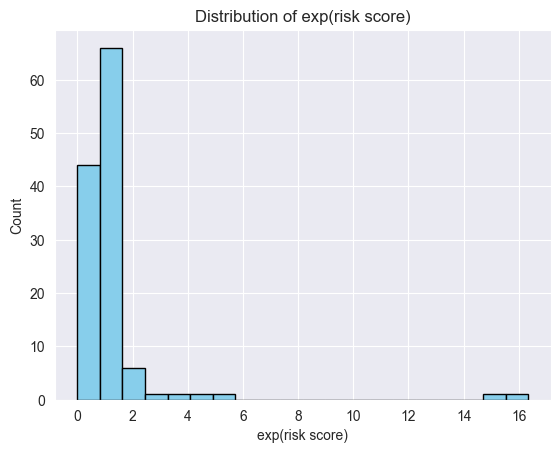

In [96]:
import matplotlib.pyplot as plt

exp_risks = np.exp(risk_scores)

plt.hist(exp_risks, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of exp(risk score)")
plt.xlabel("exp(risk score)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


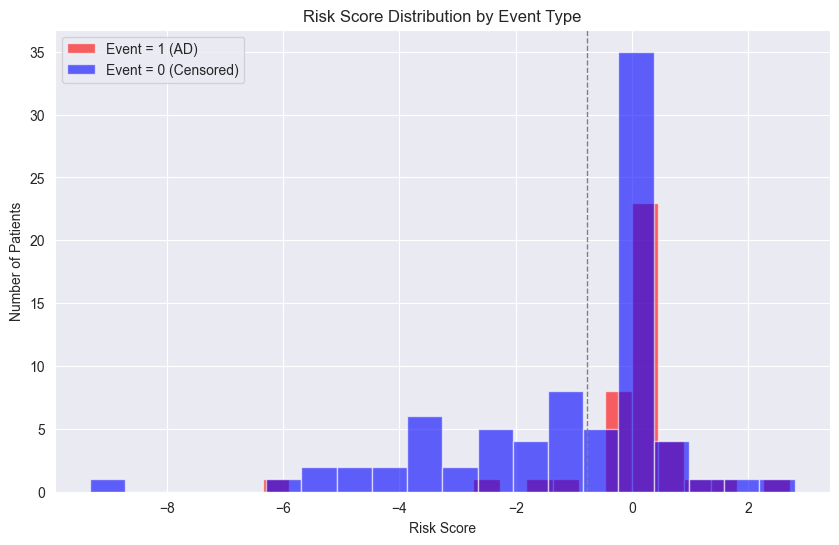

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ 모델 추론
model.eval()
with torch.no_grad():
    risk_scores = model(X_struct_val, X_image_val).detach().cpu().numpy().reshape(-1)
    events = event_val.cpu().numpy()

# ✅ 시각화
plt.figure(figsize=(10, 6))
plt.hist(risk_scores[events == 1], bins=20, alpha=0.6, color='red', label='Event = 1 (AD)')
plt.hist(risk_scores[events == 0], bins=20, alpha=0.6, color='blue', label='Event = 0 (Censored)')
plt.axvline(np.mean(risk_scores), color='gray', linestyle='dashed', linewidth=1)
plt.title('Risk Score Distribution by Event Type')
plt.xlabel('Risk Score')
plt.ylabel('Number of Patients')
plt.legend()
plt.grid(True)
plt.show()


In [98]:
i = 14  # 14번째 환자 인덱스

# ✅ Structured data
print("📊 Structured Features:")
print(X_struct_test[i].cpu())

# ✅ Image tensor
print("\n🖼️ Image Tensor (shape):", X_image_test[i].shape)

# ✅ Time to AD
print("\n⏱️ Time to AD:", time_test[i].item())

# ✅ Event (1=AD, 0=censored)
print("📌 Event:", int(event_test[i].item()))

# ✅ Risk Score
print("\n⚠️ Predicted Risk Score:", risk_scores[i])


📊 Structured Features:
tensor([76.4000, 16.0000,  1.0000,  1.0000,  0.0000,  1.0000, 22.0000, 18.0000,
        28.0000, 10.0000,  1.9767])

🖼️ Image Tensor (shape): torch.Size([3, 224, 224])

⏱️ Time to AD: 1.0157400369644165
📌 Event: 0

⚠️ Predicted Risk Score: 0.058856994


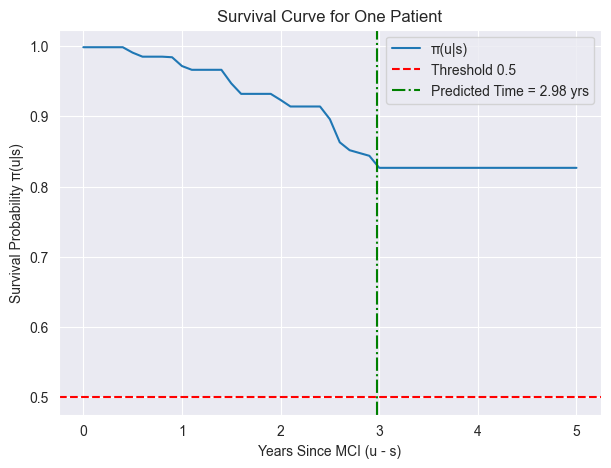

In [99]:
plot_survival_curve(risk_scores[28], H0_func, highlight_time=2.98)